# Описание обучения

### Данные

1. Берутся только id героев как фичи

### Обучение

1. Для **ML подходов:** \
Конкатинируются в вектор длины $ 2 * len(unique(id)) $ \
Для Radiant - $ len(unique(id)) $ \
Для Dire - $ len(unique(id)) $

2. Для **DL подходов:** ?

In [18]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('/Users/ankamenskiy/SmartDota/')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [19]:
import pickle
import dataclasses
import json

import sklearn
import pandas as pd
import numpy as np
import torch

import matplotlib.pyplot as plt

from src.data.api.OpenDota.pro_matches_dataloader import ProMatchesDataloader
from src.data.api.OpenDota.public_matches_dataloader import PublicMatchesDataloader

from tqdm.notebook import tqdm

## Читаем данные

In [20]:
train_path = '/Users/ankamenskiy/SmartDota/cache/public_110000_7-34b-ALL'
test_path = '/Users/ankamenskiy/SmartDota/cache/pro_10000_dups_light'

train_dataloader = PublicMatchesDataloader(0, 0)
train_dataloader.load(path=train_path)
test_dataloader = ProMatchesDataloader()
test_dataloader.load(path=test_path)

train_data = train_dataloader.data
test_data = test_dataloader.data

# ya nasral kogda kachal danniye
unique = {}
[unique.setdefault(elem.match_id, elem) for elem in test_data]
test_data = [v for k, v in unique.items()]
unique = {}
[unique.setdefault(elem.match_id, elem) for elem in train_data]
train_data = [v for k, v in unique.items()]

print(len(train_data), len(test_data))

Empty Key
Last match index: 7504377105
Last match index: 7502042193
108937 4129


## Готовим датасет

### For PUBLIC matches [TRAIN data]

In [21]:
df_train_val = pd.DataFrame()

df_train_val['target'] = [1 if match.radiant_win else 0 for match in train_data]
df_train_val['radiant_hero_ids'] = [match.radiant_team for match in train_data]
df_train_val['dire_hero_ids'] = [match.dire_team for match in train_data]

df_train_val.dropna(inplace=True)
display(df_train_val.sample(5))
df_train_val.groupby('target')['target'].count()

,target,radiant_hero_ids,dire_hero_ids
23078,1,"[45, 76, 98, 63, 8]","[29, 72, 35, 14, 71]"
61909,0,"[136, 10, 47, 7, 19]","[43, 90, 84, 129, 42]"
77455,0,"[15, 41, 98, 68, 105]","[1, 120, 114, 72, 26]"
37329,1,"[13, 60, 128, 93, 53]","[41, 40, 20, 71, 56]"
2368,1,"[13, 20, 137, 105, 48]","[63, 43, 33, 86, 62]"


target
0    44783
1    50022
Name: target, dtype: int64

### For PRO matches [TEST data]

0 - Radiant \
1 - Dire

In [22]:
pb = [elem.picks_bans for elem in test_data]

radiants, dires, targets = [], [], []

for i, elem in enumerate(test_data):
    pb = elem.picks_bans
    target = elem.pro_match_data.radiant_win # 1 if RADIANT win | 0 if DIRE win

    if pb is None or target is None:
        continue
    
    pb = sorted(filter(lambda x: x.is_pick, pb), key=lambda x: x.team)
    assert len(pb) == 10

    radiants.append([e.hero_id for e in pb[:5]])
    dires.append([e.hero_id for e in pb[5:]])
    targets.append(int(target))

df_test = pd.DataFrame()

df_test['target'] = targets
df_test['radiant_hero_ids'] = radiants
df_test['dire_hero_ids'] = dires

display(df_test.sample(5))
display(df_test.isna().sum())
df_test.groupby('target')['target'].count()

,target,radiant_hero_ids,dire_hero_ids
3733,0,"[53, 85, 69, 106, 6]","[121, 14, 49, 76, 10]"
1466,0,"[84, 86, 60, 46, 100]","[85, 43, 79, 35, 48]"
3945,0,"[71, 26, 20, 76, 48]","[102, 64, 96, 63, 106]"
284,1,"[86, 64, 14, 10, 22]","[71, 72, 11, 28, 23]"
3231,0,"[3, 20, 70, 96, 25]","[123, 29, 121, 73, 76]"


target              0
radiant_hero_ids    0
dire_hero_ids       0
dtype: int64

target
0    1990
1    2105
Name: target, dtype: int64

## If 248-dim OHE

In [126]:
from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer(sparse_output=True)

def make_hero_onehot(df):
    df1 = df.join(
            pd.DataFrame.sparse.from_spmatrix(
                mlb.fit_transform(df.pop('radiant_hero_ids')),
                index=df.index,
                columns=mlb.classes_
            )
        )
    # display(df1)

    df2 = df1.join(
            pd.DataFrame.sparse.from_spmatrix(
                mlb.fit_transform(df1.pop('dire_hero_ids')),
                index=df1.index,
                columns=mlb.classes_
            ),
            lsuffix='_radiant', 
            rsuffix='_dire'
        )
    # display(df2)
    
    return df2

print(df_train_val.shape)
df_train_val = make_hero_onehot(df_train_val).drop_duplicates()
df_test = make_hero_onehot(df_test).drop_duplicates()

display(df_train_val)
display(df_test)

(94805, 3)


,target,1_radiant,2_radiant,3_radiant,4_radiant,5_radiant,6_radiant,7_radiant,8_radiant,9_radiant,...,120_dire,121_dire,123_dire,126_dire,128_dire,129_dire,135_dire,136_dire,137_dire,138_dire
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,1,...,0,0,1,0,0,0,1,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,1,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94806,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
94807,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
94814,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
94815,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


,target,1_radiant,2_radiant,3_radiant,4_radiant,5_radiant,6_radiant,7_radiant,8_radiant,9_radiant,...,120_dire,121_dire,123_dire,126_dire,128_dire,129_dire,135_dire,136_dire,137_dire,138_dire
0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,1,0,0,1,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,1,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
4,0,0,0,0,0,1,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4090,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4091,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4092,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4093,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## If 124-dim OHE

In [23]:
NUM_HEROES = 124

with open('/Users/ankamenskiy/SmartDota/data/heroes.json', 'r') as f:
    heroes = json.loads(f.read())
    hero2pos = {hero['id']: i + 1 for i, hero in enumerate(heroes)}
    print(hero2pos)

def make_small_ohe(df):
    columns = ['target'] + [str(i + 1) for i in range(NUM_HEROES)]
    ret = []

    for _, row in tqdm(df.iterrows()):
        r = [row['target']] + [0]*NUM_HEROES

        for id in row['radiant_hero_ids']:
            r[hero2pos[id]] = 1
        for id in row['dire_hero_ids']:
            r[hero2pos[id]] = -1
        
        ret.append({col: val for col, val in zip(columns, r)})

    return pd.DataFrame(ret)

df_test_extended = make_small_ohe(df_test)
df_train_val_extended = make_small_ohe(df_train_val)

display(df_test_extended)
display(df_train_val_extended)

{1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7, 8: 8, 9: 9, 10: 10, 11: 11, 12: 12, 13: 13, 14: 14, 15: 15, 16: 16, 17: 17, 18: 18, 19: 19, 20: 20, 21: 21, 22: 22, 23: 23, 25: 24, 26: 25, 27: 26, 28: 27, 29: 28, 30: 29, 31: 30, 32: 31, 33: 32, 34: 33, 35: 34, 36: 35, 37: 36, 38: 37, 39: 38, 40: 39, 41: 40, 42: 41, 43: 42, 44: 43, 45: 44, 46: 45, 47: 46, 48: 47, 49: 48, 50: 49, 51: 50, 52: 51, 53: 52, 54: 53, 55: 54, 56: 55, 57: 56, 58: 57, 59: 58, 60: 59, 61: 60, 62: 61, 63: 62, 64: 63, 65: 64, 66: 65, 67: 66, 68: 67, 69: 68, 70: 69, 71: 70, 72: 71, 73: 72, 74: 73, 75: 74, 76: 75, 77: 76, 78: 77, 79: 78, 80: 79, 81: 80, 82: 81, 83: 82, 84: 83, 85: 84, 86: 85, 87: 86, 88: 87, 89: 88, 90: 89, 91: 90, 92: 91, 93: 92, 94: 93, 95: 94, 96: 95, 97: 96, 98: 97, 99: 98, 100: 99, 101: 100, 102: 101, 103: 102, 104: 103, 105: 104, 106: 105, 107: 106, 108: 107, 109: 108, 110: 109, 111: 110, 112: 111, 113: 112, 114: 113, 119: 114, 120: 115, 121: 116, 123: 117, 126: 118, 128: 119, 129: 120, 135: 121, 136:

0it [00:00, ?it/s]

0it [00:00, ?it/s]

,target,1,2,3,4,5,6,7,8,9,...,115,116,117,118,119,120,121,122,123,124
0,0,0,0,0,0,0,0,0,0,0,...,1,-1,0,-1,0,0,-1,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,-1,-1,0,0,0,0
2,1,0,0,0,0,0,0,0,0,-1,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,-1,1,0,0,0,0,0,0
4,0,0,0,0,0,1,0,0,0,0,...,0,-1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4090,1,-1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4091,1,-1,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
4092,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
4093,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


,target,1,2,3,4,5,6,7,8,9,...,115,116,117,118,119,120,121,122,123,124
0,1,0,0,0,0,0,0,-1,0,0,...,0,0,0,0,0,0,0,1,0,0
1,1,0,0,0,0,0,0,0,0,1,...,0,0,-1,0,0,0,-1,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,-1,0
4,1,0,0,0,0,0,-1,0,1,0,...,0,0,0,0,0,1,0,1,-1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94800,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
94801,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
94802,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
94803,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [24]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

RANDOM_STATE = 42

X = df_train_val_extended.drop(['target'], axis=1).to_numpy()
y = df_train_val_extended['target'].to_numpy()
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=RANDOM_STATE)

X_test = df_test_extended.drop(['target'], axis=1).to_numpy()
y_test = df_test_extended['target'].to_numpy()

### Help functions

In [25]:
def plot_prob_hist(probas):
    dire_win, radiant_win = probas[:, 0], probas[:, 1]
    
    plt.hist(dire_win, color='r', alpha = 0.3, bins=40)
    plt.hist(radiant_win, color='g', alpha = 0.6, bins=40)

def compare_results(y_pred, y_true, X_val):
    df = pd.DataFrame()
    df['y_pred'] = y_pred
    df['y_true'] = y_true
    display(df)

def make_prediction(model, heroes):
    df = pd.DataFrame()
    df['radiant_hero_ids'] = heroes['radiant']
    df['dire_hero_ids'] = heroes['dire']

    df = make_hero_onehot(df)
    X_pred = df.to_numpy()

    probas = model.predict_proba(X_pred)
    print(probas)
    probas = np.exp(probas) / np.sum(np.exp(probas)) # softmax

    return {
        'dire': probas[0],
        'radiant': probas[1]
    }

# LogReg

# Разобраться с валидацией

LogisticRegression(C=0.3, class_weight='balanced', max_iter=200, penalty=None, solver='sag')

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import make_scorer, f1_score, precision_score, balanced_accuracy_score


params_grid = {
    'penalty': [None, 'l1', 'l2'],
    'C': [0.2, 0.25, 0.3],
    'class_weight': [
        {
        0: 0.53, 
        1: 0.47
        },
        'balanced'
        ],
    'solver': ['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'],
    'max_iter': [200]
}

logreg_gridsearch = GridSearchCV(
    estimator=LogisticRegression(),
    param_grid=params_grid,
    scoring=make_scorer(f1_score),
    cv=10,
    n_jobs=-1
)

logreg_gridsearch.fit(X_train, y_train)
logreg_model = logreg_gridsearch.best_estimator_

print(logreg_gridsearch.cv_results_)
print(logreg_model.get_params)

              precision    recall  f1-score   support

           0       0.53      0.57      0.55      4478
           1       0.59      0.55      0.57      5003

    accuracy                           0.56      9481
   macro avg       0.56      0.56      0.56      9481
weighted avg       0.56      0.56      0.56      9481



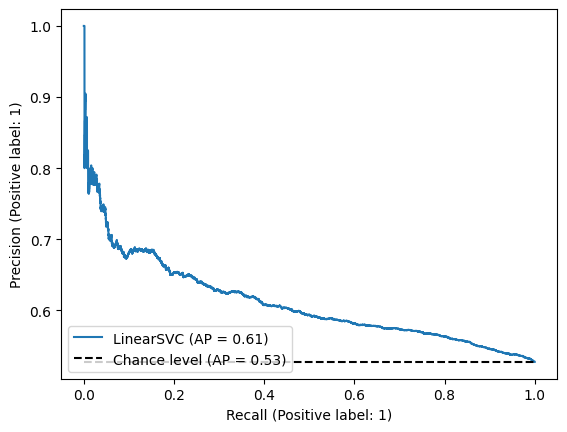

In [34]:
# XXX, yyy = X_test, y_test
XXX, yyy = X_val, y_val

preds = logreg_model.predict(XXX)
probas = logreg_model.predict_proba(XXX)

plot_prob_hist(probas)
compare_results(preds, yyy, XXX)
print(classification_report(yyy, preds))

sklearn.metrics.PrecisionRecallDisplay.from_estimator(
    logreg_model, XXX.copy(), yyy.copy(), name="LinearSVC", plot_chance_level=True
)

# Catboost

In [221]:
from catboost import CatBoostClassifier


cbt_model = CatBoostClassifier(
                iterations=15_000,                
                learning_rate=6e-3,
                depth=3
            )

cbt_model.fit(
    X_train,
    y_train,
    eval_set=(X_val, y_val),
    plot=True,
    silent=True,
    use_best_model=True
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

,preds,prob_dire,prob_radiant,X_test,y_test
0,1,0.394255,0.605745,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0
3,0,0.603765,0.396235,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0
4,1,0.437307,0.562693,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, ...",0
5,1,0.290635,0.709365,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0
7,1,0.434701,0.565299,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1
...,...,...,...,...,...
4079,1,0.373473,0.626527,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1
4084,1,0.439276,0.560724,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0
4085,1,0.427637,0.572363,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1
4087,0,0.584680,0.415320,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1


(1891, 2)


,y_pred,y_true
0,1,0
1,0,0
2,1,0
3,1,0
4,1,1
...,...,...
1886,1,1
1887,1,0
1888,1,1
1889,0,1


              precision    recall  f1-score   support

           0       0.56      0.33      0.41       894
           1       0.56      0.77      0.65       997

    accuracy                           0.56      1891
   macro avg       0.56      0.55      0.53      1891
weighted avg       0.56      0.56      0.54      1891

Lost 0.538 samples


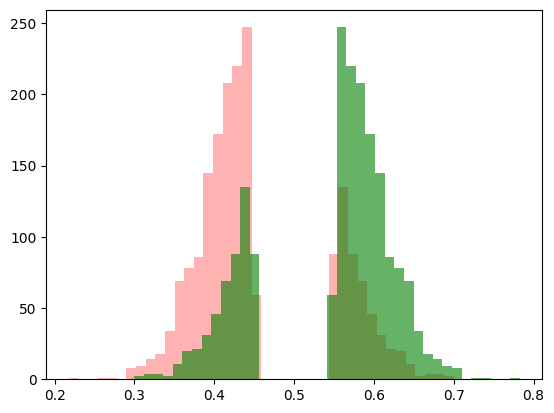

In [51]:
THRESHOLD = 0.55

df = pd.DataFrame()

preds = cbt_model.predict(X_test)
probas = cbt_model.predict_proba(X_test)

print('Accuracy:', accuracy_score(y_test, preds))

df['preds'] = preds.tolist()
df['prob_dire'] = probas[:, 0].tolist()
df['prob_radiant'] = probas[:, 1].tolist()
df['X_test'] = X_test.tolist()
df['y_test'] = y_test.tolist()

df_thr = df[(df['prob_dire'] > THRESHOLD) | (df['prob_radiant'] > THRESHOLD)]
display(df_thr)

probas_thr = np.concatenate(
    (
        df_thr['prob_dire'].to_numpy().reshape(-1, 1), 
        df_thr['prob_radiant'].to_numpy().reshape(-1, 1)
    ), axis=1)
print(probas_thr.shape)
preds_thr = df_thr['preds'].to_numpy()
X_test_thr = df_thr['X_test'].to_numpy()
y_test_thr = df_thr['y_test'].to_numpy()

plot_prob_hist(probas_thr)
compare_results(preds_thr, y_test_thr, X_test_thr)
print(classification_report(y_test_thr, preds_thr))
print(f'Lost {1 - df_thr.shape[0] / df.shape[0]:.3f} samples')

[1 0 0 ... 1 0 1]
[1 0 0 ... 1 0 1]


,y_pred,y_true
0,1,1
1,0,0
2,0,0
3,0,0
4,1,1
...,...,...
1977,1,1
1978,1,1
1979,1,1
1980,0,0


              precision    recall  f1-score   support

           0       0.90      0.92      0.91       946
           1       0.92      0.91      0.91      1036

    accuracy                           0.91      1982
   macro avg       0.91      0.91      0.91      1982
weighted avg       0.91      0.91      0.91      1982



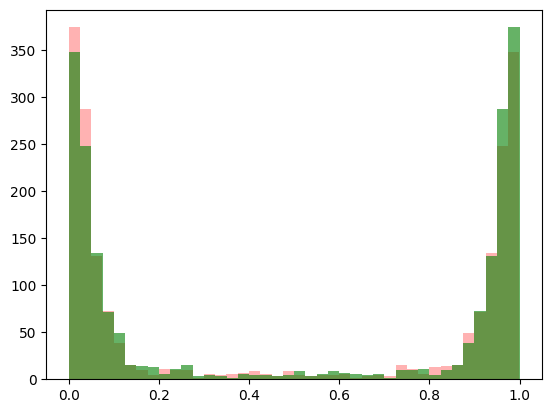

In [ ]:
preds = cbt_model.predict(X_val)
probas = cbt_model.predict_proba(X_val)

plot_prob_hist(probas)
compare_results(preds, y_val, X_val)
print(classification_report(y_val, preds))

In [15]:
model_name = 'HeroIds_0.91-F1.cbm'

cbt_model.save_model(
    fname='/Users/ankamenskiy/SmartDota/models/catboost/' + model_name,
    format="cbm"
)

In [33]:
import json
import sys
sys.path.append('../')

from lib.results_view import make_single_prediction

# print('LogReg:\n', make_single_prediction(logreg_model, 7599378829))
print('-'*50)
print('CatBoost:\n', make_single_prediction(cbt_model, 7599358486))

--------------------------------------------------
CatBoost:
 {'result': 'Radiant', 'dire': '0.28', 'radiant': '0.72'}
